Realizando o trabalho do artigo "PREVISÕES HIDROCLIMÁTICAS PARA A BACIA DO RIO NEGRO UTILIZANDO APRENDIZADO DE MÁQUINA", dos autores Alejandro da Rocha Loureiro, Ian Mateus Ribeiro de Souza, Milton Honório Pinheiro Neto, Francis Wagner Silva Correia, Mario Augusto Bessa de Figueiredo, Weslley de Brito Gomes, Leonardo Alves Vergasta

DOI: 10.51859/AMPLLA.3ASAC17-4\
Fonte: https://ampllaeditora.com.br/books/2024/05/ASAC2023.pdf

In [1]:
# Bibliotecas
from modulos import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

## Estações

Os dados foram obtidos da Agência Nacional de Águas e Saneamento Básico (ANA) em https://www.snirh.gov.br/hidroweb/serieshistoricas

1. 14300000\
Nome Estação : PARI CACHOEIRA \
Bacia : 1 - RIO AMAZONAS \
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,.... \
Rio : RIO TIQUIÉ \
Estado : AMAZONAS \
Município : SÃO GABRIEL DA CACHOEIRA \
Latitude : 0.2494 \
Longitude : -69.785


2. 14550000\
Nome Estação : MALOCA DO CONTÃO \
Bacia : 1 - RIO AMAZONAS \
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,....\
Rio : RIO COTINGO\
Estado : RORAIMA\
Município : PACARAIMA\
Latitude : 4.1675\
Longitude : -60.5289

3. 14845000\
Nome Estação : FAZENDA SÃO JOSÉ \
Bacia : 1 - RIO AMAZONAS\
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,....\
Rio : RIO JAUAPERI\
Estado : RORAIMA\
Município : RORAINÓPOLIS\
Latitude : 0.5178\
Longitude : -60.4661

4. 14990000\
Nome Estação : MANAUS\
Bacia : 1 - RIO AMAZONAS\
SubBacia : 14 - RIO SOLIMÕES,NEGRO,BRANCO,...\
Rio : RIO NEGRO\
Estado : AMAZONAS\
Município : MANAUS\
Latitude : -3.1383\
Longitude : -60.0272

## Visualizando os dados 

In [2]:
# Abrindo o arquivo CSV
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14300000.csv',
    'dados_diarios_estacao_14550000.csv',
    'dados_diarios_estacao_14845000.csv',
    'dados_diarios_estacao_14990000.csv'
]

dados = eda.data_processing(path, '2000-01-01', '2020-12-31', arquivos)
dados

,14300000,14550000,14845000,14990000
Data,,,,
2000-01-01,369.0,227.0,262.0,1915.0
2000-01-02,371.0,191.0,256.0,1931.0
2000-01-03,362.0,170.0,252.0,1947.0
2000-01-04,356.0,183.0,247.0,1960.0
2000-01-05,352.0,212.0,245.0,1969.0
...,...,...,...,...
2020-12-27,534.0,238.0,627.0,2062.0
2020-12-28,502.0,216.0,625.0,2072.0
2020-12-29,509.0,212.0,629.0,2080.0


In [3]:
# Separando os dados em treino e teste
# Treino: até 31 de dezembro de 2014
# Teste: de 1º de janeiro de 2015 e diante
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

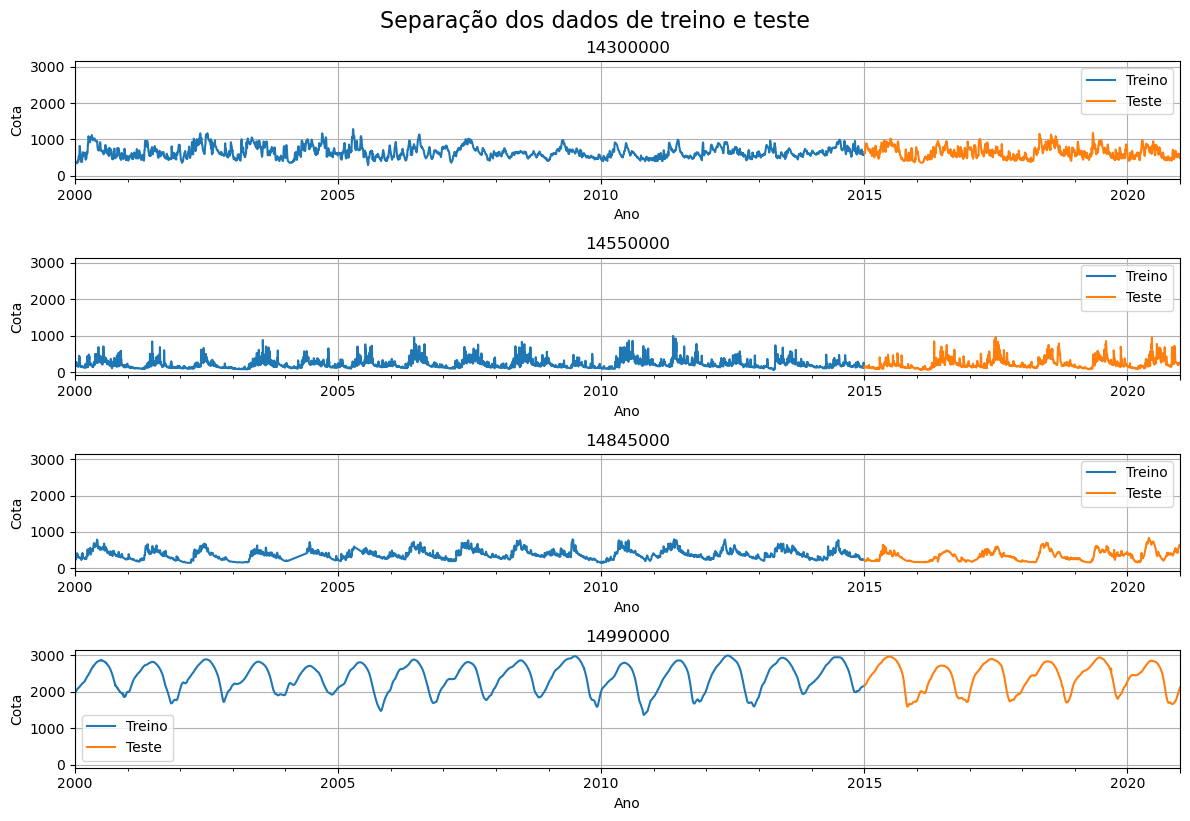

In [4]:
# Plotando os dados de treino e teste

fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharey=True)
fig.subplots_adjust(hspace=1)
ax = ax.ravel()

for i, col in enumerate(dados):
    treino[col].plot(ax=ax[i], label='Treino')
    teste[col].plot(ax=ax[i], label='Teste')
    ax[i].set_title(col)
    ax[i].set_ylabel('Cota')
    ax[i].set_xlabel('Ano')
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.suptitle('Separação dos dados de treino e teste', fontsize=16, y=1.02)
plt.show()

### Funções e grades

In [5]:
# Função para treinar o modelo

def treinar_modelo(modelo, treino, teste):
    # Criação de batches
    window_length = 365
    shifts = np.arange(1,window_length+1)
    # Criação de dictionário de dados defasados
    x_shifts = {'lag_{}'.format(ii): treino.shift(ii) for ii in shifts}
    # Converter os shifts em um dataframe
    x_shifts = pd.DataFrame(x_shifts)
    x_shifts.fillna(0, inplace=True)

    # Normalização
    x_scale = MinMaxScaler()
    x_shifts_scaled = x_scale.fit_transform(x_shifts.iloc[window_length:].values)

    y_scale = MinMaxScaler()
    treino_scaled = y_scale.fit_transform(treino.iloc[window_length:].values.reshape(-1,1)).ravel()

    # Loop de Treinamento
    # modelo.fit(x_shifts, treino)
    modelo.fit(x_shifts_scaled, treino_scaled)

    test_predictions = []
    first_eval_batch = treino_scaled[-window_length:]
    # first_eval_batch = treino[-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        # current_pred = modelo.predict(current_batch)[0]
        # test_predictions.append(current_pred)
        # current_batch = np.append(current_batch[:,1:], [[current_pred]],axis=1)

        current_pred = modelo.predict(current_batch).reshape(-1,1)
        current_pred_inv = y_scale.inverse_transform(current_pred)[0][0]
        test_predictions.append(current_pred_inv)
        current_batch = np.append(current_batch[:,1:], current_pred,axis=1)
    return test_predictions

In [6]:
# Função para plotar os resultados

def plot_resultado(resultados, teste):
    dfs = []

    for i, resultado in enumerate(resultados):
        name = resultado[len(resultado)-1]

        y_pred = None
        if name == 'MLP' or name == 'RF':
            y_pred = pd.DataFrame(resultado[4])
        else:
            y_pred = pd.DataFrame(resultado[2])
        y_pred.index = teste.index

        dfs.append(y_pred)

        r2 = r2_score(teste, y_pred)
        rmse = root_mean_squared_error(teste, y_pred)
        mape = mean_absolute_percentage_error(teste, y_pred)
        mae = mean_absolute_error(teste, y_pred)

        arch = resultado[0]
        print(f'Modelo {name}:')
        print(f"Melhor arquitetura: {arch}")
        if name == 'MLP' or name == 'RF':
            print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {(mape*100):.3f}%, R²: {resultado[1]:.3f} +- {resultado[2]:.3f}, Melhor R²: {resultado[3]:.3f}\n')
        else:
            print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {(mape*100):.3f}%, R²: {r2:.3f}\n')

    plt.figure(figsize=(16, 4))
    plt.plot(teste, label='Observado')
    plt.plot(dfs[0], linestyle='--', label='MLP')
    plt.plot(dfs[1], linestyle='--', label='RF')
    plt.plot(dfs[2], linestyle='--', label='SVR')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.title(f'Predição de Cotas - Estação {teste.name}')
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

In [7]:
# Busca em grade MLP
hl = [(11, 11), (15, 15), (20, 10), (20, 20), (30, 30)]
activation = ['relu', 'identity', 'tanh']
lri = [0.005, 0.01]

grid1 = list(product(hl, activation, lri))

In [8]:
def train_mlp_iter(arch, treino, teste):
    mlp = MLPRegressor(
        hidden_layer_sizes=arch[0],
        activation=arch[1],
        max_iter=1000,
        learning_rate_init=arch[2],
        early_stopping=True,
        n_iter_no_change=10
    )

    resultado = treinar_modelo(mlp, treino, teste)

    r2 = r2_score(teste, resultado)

    return r2, resultado

In [9]:
# Busca em grade RF
msp = [2, 3, 5]
msl = [2, 3, 5]

grid2 = list(product(msp, msl))

In [10]:
def train_rf_iter(arch, treino, teste):
    rf = RandomForestRegressor(
        min_samples_split=arch[0],
        min_samples_leaf=arch[0]
    )

    resultado = treinar_modelo(rf, treino, teste)

    r2 = r2_score(teste, resultado)

    return r2, resultado

In [11]:
# Busca em grade SVR
tol = [0.005, 0.001, 0.0005]
C = [1, 0.75, 0.5]
epsilon = [0.1, 0.25, 0.5]

grid3 = list(product(tol, C, epsilon))

In [12]:
def train_svr(arch, treino, teste):
    svr = SVR(
        tol=arch[0],
        C=arch[1],
        epsilon=arch[2]
    )

    resultado = treinar_modelo(svr, treino, teste)

    r2 = r2_score(teste, resultado)

    return r2, resultado

In [16]:
def treinamento(treino, teste, grid1, grid2, grid3):
    mlps = []
    rfs = []
    svrs = []

    for arch in grid1:
        resultado1 = Parallel(n_jobs=24)(
            delayed(train_mlp_iter)(arch, treino, teste) for _ in range(200)
        )
        r2s, _ = zip(*resultado1)
        r2_mean = np.mean(r2s)
        r2_std = np.std(r2s)
        best_r2, best_pred = max(resultado1, key=lambda x:x[0])

        mlps.append([arch, r2_mean, r2_std, best_r2, best_pred, 'MLP'])
    melhor_mlp = max(mlps, key=lambda x:x[1])

    print("MLP concluído")

    for arch in grid2:
        resultado2 = Parallel(n_jobs=24)(
            delayed(train_rf_iter)(arch, treino, teste) for _ in range(200)
        )
        r2s, _ = zip(*resultado2)
        r2_mean = np.mean(r2s)
        r2_std = np.std(r2s)
        best_r2, best_pred = max(resultado2, key=lambda x:x[0])

        rfs.append([arch, r2_mean, r2_std, best_r2, best_pred, 'RF'])
    melhor_rf = max(rfs, key=lambda x:x[1])

    print("RF Concluído")
    
    for arch in grid3:
        best_r2, best_pred = train_svr(arch, treino, teste)

        svrs.append([arch, best_r2, best_pred, 'SVR'])
    melhor_svr = max(svrs, key=lambda x:x[1])

    print("SVR Concluído")
    resultados = [melhor_mlp, melhor_rf, melhor_svr]

    print(f"\n=================================\n")

    plot_resultado(resultados, teste)

##### São Gabriel da Cachoeira

MLP concluído
RF Concluído
SVR Concluído


Modelo MLP:
Melhor arquitetura: ((20, 10), 'relu', 0.01)
MAE: 120.900, RMSE: 149.759, MAPE: 19.524%, R²: -0.165 +- 0.139, Melhor R²: 0.116

Modelo RF:
Melhor arquitetura: (5, 3)
MAE: 141.781, RMSE: 172.792, MAPE: 24.197%, R²: -0.192 +- 0.006, Melhor R²: -0.177

Modelo SVR:
Melhor arquitetura: (0.0005, 1, 0.25)
MAE: 150.343, RMSE: 175.390, MAPE: 27.211%, R²: -0.213



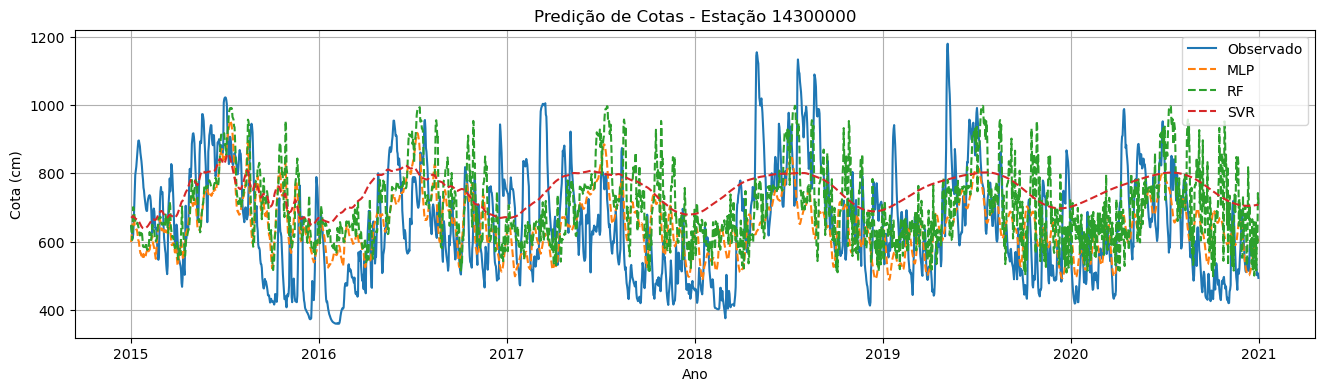

In [17]:
treinamento(treino['14300000'], teste['14300000'], grid1, grid2, grid3)

##### Pacaraima

MLP concluído
RF Concluído
SVR Concluído


Modelo MLP:
Melhor arquitetura: ((20, 20), 'identity', 0.005)
MAE: 75.257, RMSE: 114.916, MAPE: 31.840%, R²: 0.110 +- 0.085, Melhor R²: 0.312

Modelo RF:
Melhor arquitetura: (5, 5)
MAE: 88.445, RMSE: 140.551, MAPE: 30.938%, R²: -0.052 +- 0.009, Melhor R²: -0.029

Modelo SVR:
Melhor arquitetura: (0.001, 0.5, 0.1)
MAE: 98.100, RMSE: 127.639, MAPE: 51.251%, R²: 0.151



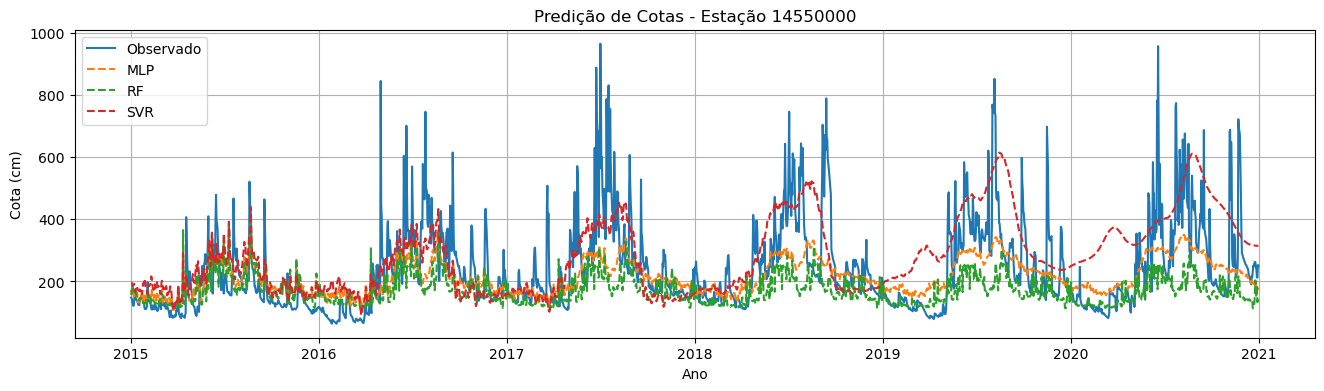

In [18]:
treinamento(treino['14550000'], teste['14550000'], grid1, grid2, grid3)

##### Rorainopólis

MLP concluído
RF Concluído
SVR Concluído


Modelo MLP:
Melhor arquitetura: ((30, 30), 'identity', 0.01)
MAE: 80.435, RMSE: 102.572, MAPE: 25.954%, R²: 0.343 +- 0.269, Melhor R²: 0.467

Modelo RF:
Melhor arquitetura: (5, 3)
MAE: 86.762, RMSE: 110.245, MAPE: 28.277%, R²: 0.377 +- 0.003, Melhor R²: 0.384

Modelo SVR:
Melhor arquitetura: (0.001, 0.5, 0.1)
MAE: 122.357, RMSE: 146.464, MAPE: 45.885%, R²: -0.087



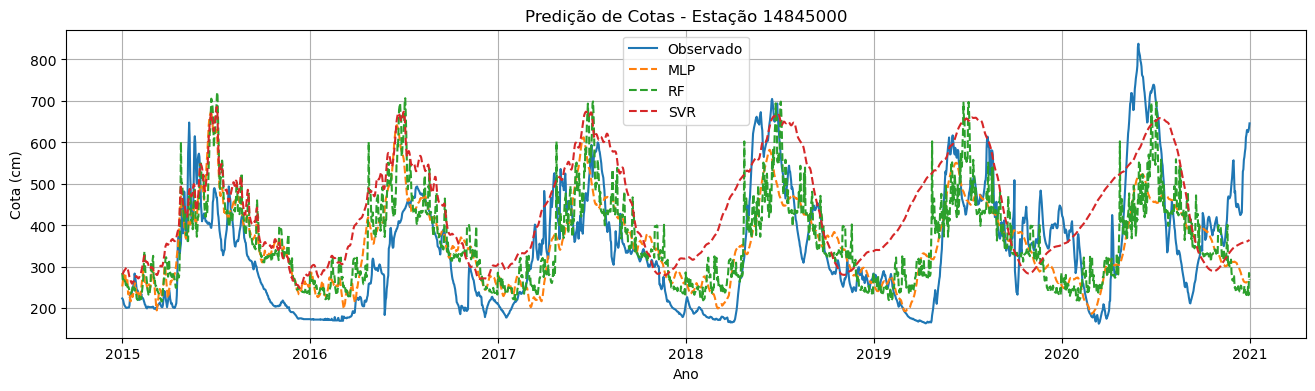

In [19]:
treinamento(treino['14845000'], teste['14845000'], grid1, grid2, grid3)

##### Manaus

MLP concluído
RF Concluído
SVR Concluído


Modelo MLP:
Melhor arquitetura: ((30, 30), 'tanh', 0.005)
MAE: 118.060, RMSE: 151.153, MAPE: 5.507%, R²: 0.746 +- 0.037, Melhor R²: 0.855

Modelo RF:
Melhor arquitetura: (5, 5)
MAE: 161.534, RMSE: 207.289, MAPE: 7.652%, R²: 0.726 +- 0.001, Melhor R²: 0.728

Modelo SVR:
Melhor arquitetura: (0.005, 1, 0.1)
MAE: 195.213, RMSE: 244.580, MAPE: 8.901%, R²: 0.621



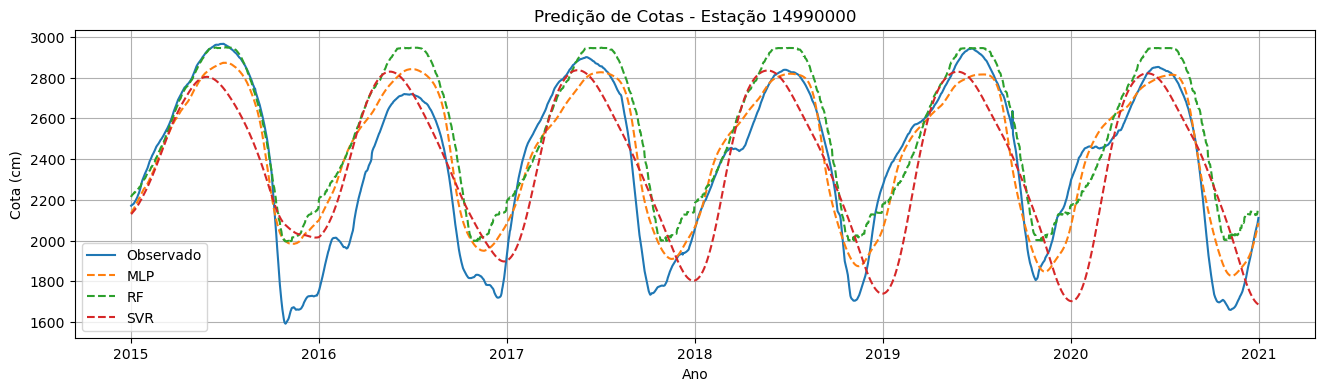

In [20]:
treinamento(treino['14990000'], teste['14990000'], grid1, grid2, grid3)